## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import math
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
from sklearn.metrics import mean_squared_error
%matplotlib qt

In [2]:
def read_data(file_name):    
    with open(file_name, mode='rb') as f:
        data = pickle.load(f)
        
    return data['objpoints'], data['imgpoints']


def save_data(file_name, objpoints, imgpoints):
    print('Save processed data...')
    data = {'objpoints': objpoints, 'imgpoints': imgpoints}

    with open(file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 
        
    print('Done!\n')   

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
print(objp.shape)

(54, 3)


In [4]:
# Make a list of calibration images
images = np.sort(glob.glob('./camera_cal/calibration*.jpg'))
print(images)

['./camera_cal\\calibration01.jpg' './camera_cal\\calibration02.jpg'
 './camera_cal\\calibration03.jpg' './camera_cal\\calibration04.jpg'
 './camera_cal\\calibration05.jpg' './camera_cal\\calibration06.jpg'
 './camera_cal\\calibration07.jpg' './camera_cal\\calibration08.jpg'
 './camera_cal\\calibration09.jpg' './camera_cal\\calibration10.jpg'
 './camera_cal\\calibration11.jpg' './camera_cal\\calibration12.jpg'
 './camera_cal\\calibration13.jpg' './camera_cal\\calibration14.jpg'
 './camera_cal\\calibration15.jpg' './camera_cal\\calibration16.jpg'
 './camera_cal\\calibration17.jpg' './camera_cal\\calibration18.jpg'
 './camera_cal\\calibration19.jpg' './camera_cal\\calibration20.jpg']


In [5]:
# Arrays to store object points and image points from all the images.

objpoints1 = [] # 3d points in real world space
imgpoints1 = [] # 2d points in image plane.
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    plt.ion()
    if ret == True:
        print('>> \'{0}\': Found'.format(fname))
        objpoints1.append(objp)
        imgpoints1.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #helper.plot_image(img, title=fname)
    else:
        print('>> \'{0}\': Not Found'.format(fname))

# plt.close()
file_name = 'chessboard_corners.p'
save_data(file_name, objpoints1, imgpoints1)

>> './camera_cal\calibration01.jpg': Not Found
>> './camera_cal\calibration02.jpg': Found
>> './camera_cal\calibration03.jpg': Found
>> './camera_cal\calibration04.jpg': Not Found
>> './camera_cal\calibration05.jpg': Not Found
>> './camera_cal\calibration06.jpg': Found
>> './camera_cal\calibration07.jpg': Found
>> './camera_cal\calibration08.jpg': Found
>> './camera_cal\calibration09.jpg': Found
>> './camera_cal\calibration10.jpg': Found
>> './camera_cal\calibration11.jpg': Found
>> './camera_cal\calibration12.jpg': Found
>> './camera_cal\calibration13.jpg': Found
>> './camera_cal\calibration14.jpg': Found
>> './camera_cal\calibration15.jpg': Found
>> './camera_cal\calibration16.jpg': Found
>> './camera_cal\calibration17.jpg': Found
>> './camera_cal\calibration18.jpg': Found
>> './camera_cal\calibration19.jpg': Found
>> './camera_cal\calibration20.jpg': Found
Save processed data...
Done!



In [6]:
file_name = 'chessboard_corners.p'
objpoints, imgpoints = read_data(file_name)

In [7]:
print('>> objectpoints length: {0}'.format(len(objpoints)))
print('>> shape of objectpoints element: {0}'.format(objpoints[0].shape))
print('>> {0} row of {1} objectpoints element: {2}'.format('14th', '1st', objpoints[0][13]))
print()
print('>> imgpoints length: {0}'.format(len(imgpoints)))
print('>> shape of imgpoints element: {0}'.format(imgpoints[0].shape))
print('>> {0} row of {1} imgpoints element: {2}'.format('47th', '2nd', imgpoints[1][46]))

>> objectpoints length: 17
>> shape of objectpoints element: (54, 3)
>> 14th row of 1st objectpoints element: [4. 1. 0.]

>> imgpoints length: 17
>> shape of imgpoints element: (54, 1, 2)
>> 47th row of 2nd imgpoints element: [[253.50026 570.71   ]]


In [8]:
def cal_undistort(img, objpoints, imgpoints):
    """
    - takes an image(RGB), object points, and image points,
    - performs the camera calibration, image distortion correction, and 
    - returns the undistorted image
    """
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def plot_original_undistort(image, unditorted_image, save=False, save_path = None):
    # plot 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=36)
    ax1.axis('off')
    ax2.imshow(unditorted_image)
    ax2.set_title('Undistorted Image', fontsize=36)
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save the image
    if (save):
        if(save_path is None): raise Exception('"save_pathe" is None!')
        f.savefig(save_path, dpi=100)

>> Test image: calibration05.jpg


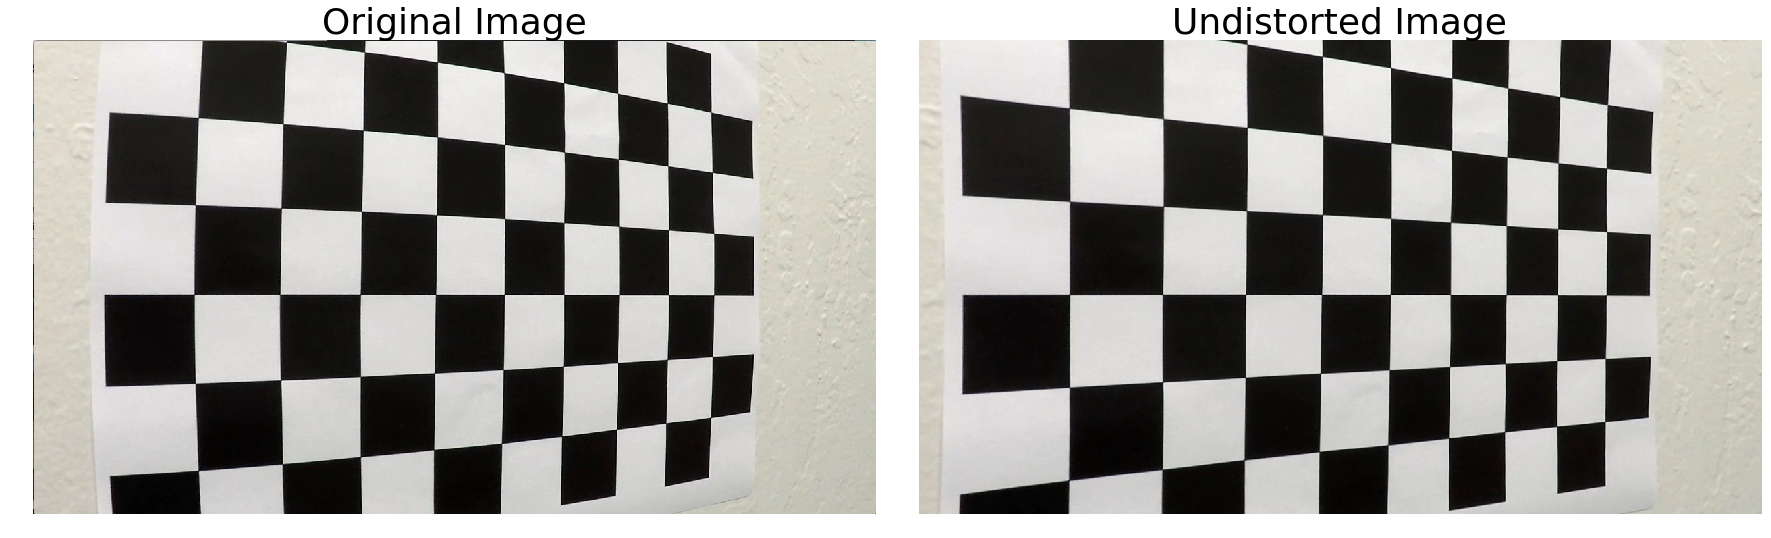

In [9]:
# Undistorting a test image:
idx = 5
image_test_name = 'calibration{:0>2}.jpg'.format(idx)
image_test_path = './camera_cal/{0}'.format(image_test_name)
print('>> Test image: {0}'.format(image_test_name))

image_test = cv2.imread(image_test_path)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test_unditorted = cal_undistort(image_test, objpoints, imgpoints)

# plot (and save)
plot_original_undistort(
    image_test, 
    image_test_unditorted, 
    save=True, 
    save_path = './res/undistort_output_{0}'.format(image_test_name))

### Provide an example of a distortion-corrected image

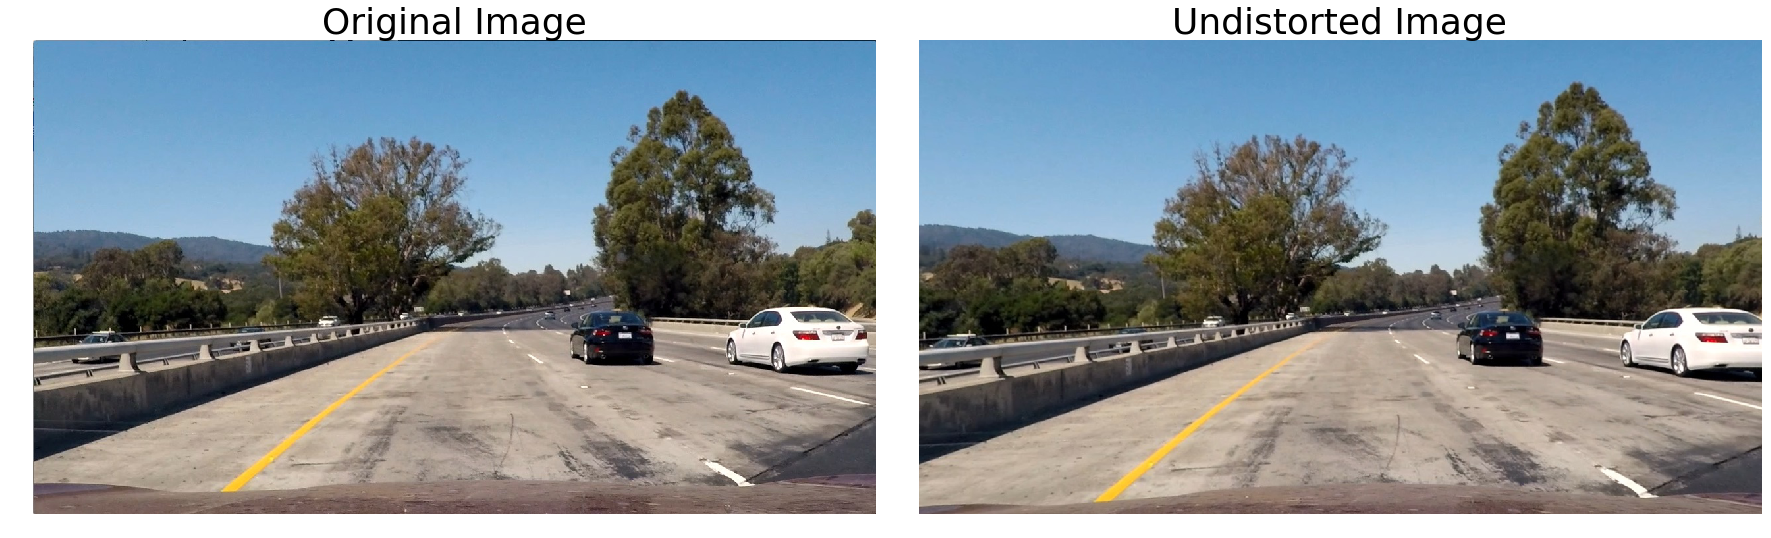

In [10]:
idx = 1
image_test_name = 'test{:1}.jpg'.format(idx)
image_test_path = './test_images/{0}'.format(image_test_name)
image_test = cv2.imread(image_test_path)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test_unditorted = cal_undistort(image_test, objpoints, imgpoints)

# plot (and save)
plot_original_undistort(
    image_test, 
    image_test_unditorted, 
    save=True, 
    save_path = './res/undistort_output_{0}'.format(image_test_name))

## Helper Functions
Below are some helper functions to help get you started. They should look familiar from the lesson!

In [11]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
#     print(type(img))
#     print(img.shape)
#     print(img.dtype)
    return cv2.Canny(np.uint8(img), low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [12]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg',
 'test7.jpg',
 'test7.png',
 'test8.jpg',
 'vlcsnap-error587.png',
 'vlcsnap-error653.png',
 'vlcsnap-error693.png',
 'vlcsnap-error882.png']

## Implementation
Here I implemented the codes to add pipeline and green zone to a road image. I splited up the implementation into multiple parts and put every part in a function to make code readable and reusable. Also there are multiple variables needs to be tuned that I put them in one place and you can find then in the next section.

In [13]:
def get_pt_src_dst(rows, cols):
    pt_src = np.float32([
        [cols * (1 - coef_w_top) / 2, rows * offset_v_top], \
        [cols * (1 + coef_w_top*1.2) / 2, rows * offset_v_top], \
        [cols * (1 - coef_w_dwn) / 2, rows * (1 - offset_v_dwn)], \
        [cols * (1 + coef_w_dwn) / 2, rows * (1 - offset_v_dwn)]])
    
    pt_dst = np.float32([[0, 0], [cols, 0], [0, rows], [cols, rows]])
    
    return pt_src, pt_dst


def perspective_transform(img, pt_src, pt_dst, rows, cols):
    M = cv2.getPerspectiveTransform(pt_src, pt_dst)
    img_trans = cv2.warpPerspective(img, M, (cols, rows))
    return np.copy(img_trans)
    

def transform_to_rectangle(img, rows, cols, prefix = None, _plot=False):
    pt_src, pt_dst = get_pt_src_dst(rows, cols)
    img_trans = perspective_transform(img, pt_src, pt_dst, rows, cols)
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(img_trans)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_img_trans_org2rec.jpg'.format(prefix),img_trans)
       
    return np.copy(img_trans)


def transform_back_to_origin(img, rows, cols, prefix = None, _plot=False):
    pt_dst, pt_src = get_pt_src_dst(rows, cols)
    img_trans = perspective_transform(img, pt_src, pt_dst, rows, cols)
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(img_trans)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_img_trans_rec2org.jpg'.format(prefix), cv2.cvtColor(img_trans, cv2.COLOR_RGB2BGR))
        
    return np.copy(img_trans)


def get_new_figure():
    return plt.figure(figsize=(12, 6.75), dpi= 100, facecolor='w', edgecolor='k')


def get_binary_warped(img, s_thresh=(170, 255), sx_thresh=(20, 100), _plot = False, prefix=None):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(sxbinary*255)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_sxbinary.jpg'.format(prefix), sxbinary*255)
        
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(s_binary*255)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_s_binary.jpg'.format(prefix), s_binary*255)
        
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.zeros_like(sxbinary)
    color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(color_binary*255)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_color_binary.jpg'.format(prefix), color_binary*255)
    
    return color_binary


def find_pipeline_with_sliding_window(binary_warped, _draw_window=False, _plot = False, prefix=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if(_draw_window):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    cols = binary_warped.shape[0]
    if(left_line is not None and right_line is not None):
        bleft_fit, bright_fit = left_line.current_fit, right_line.current_fit
        if(bleft_fit is not None):
            bleft_fitx = bleft_fit[0]*lefty**2 + bleft_fit[1]*lefty + bleft_fit[2]
            deviation = np.divide(leftx - bleft_fitx, cols)
            #print('buffer predict left')
            th = 0.02
            idx = deviation > th
            deviation[idx] = th
            idx = deviation < -th
            deviation[idx] = -th

            leftx = bleft_fitx + deviation * cols

            # Update variables
            lefty = np.concatenate((lefty, lefty))  
            leftx = np.concatenate((leftx, bleft_fitx))
            
        if(bright_fit is not None):
            bright_fitx = bright_fit[0]*righty**2 + bright_fit[1]*righty + bright_fit[2]
            deviation = np.divide(rightx - bright_fitx, cols)
            #print('buffer predict right')

            th = 0.02
            idx = deviation > th
            deviation[idx] = th
            idx = deviation < -th
            deviation[idx] = -th

            rightx = bright_fitx + deviation * cols

            # Update variables
            righty = np.concatenate((righty, righty))  
            rightx = np.concatenate((rightx, bright_fitx))

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(_plot):
        # Generate x and y values for plotting
        fig=get_new_figure()
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
        if (prefix is not None):
            fig.savefig('./res/{0}_out_img_1_2.jpg'.format(prefix), dpi=100)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_out_img_1_1.jpg'.format(prefix), out_img)
    
    return left_fit, right_fit
    

def find_pipeline_without_sliding_window(binary_warped, _plot = False, prefix=None):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    cols = binary_warped.shape[0]
    if(left_line is not None and right_line is not None):
        bleft_fit, bright_fit = left_line.current_fit, right_line.current_fit
        if(bleft_fit is not None):
            bleft_fitx = bleft_fit[0]*lefty**2 + bleft_fit[1]*lefty + bleft_fit[2]
            deviation = np.divide(leftx - bleft_fitx, cols)
            #print('buffer predict left')
            th = 0.02
            idx = deviation > th
            deviation[idx] = th
            idx = deviation < -th
            deviation[idx] = -th

            leftx = bleft_fitx + deviation * cols

            # Update variables
            lefty = np.concatenate((lefty, lefty))  
            leftx = np.concatenate((leftx, bleft_fitx))
            
        if(bright_fit is not None):
            bright_fitx = bright_fit[0]*righty**2 + bright_fit[1]*righty + bright_fit[2]
            deviation = np.divide(rightx - bright_fitx, cols)
            #print('buffer predict right')

            th = 0.02
            idx = deviation > th
            deviation[idx] = th
            idx = deviation < -th
            deviation[idx] = -th

            rightx = bright_fitx + deviation * cols

            # Update variables
            righty = np.concatenate((righty, righty))  
            rightx = np.concatenate((rightx, bright_fitx))
            
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(_plot):
        # Generate x and y values for plotting
        fig = get_new_figure()
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        if (prefix is not None):
            fig.savefig('./res/{0}_out_img_2_2.jpg'.format(prefix), dpi=100)
        
    if (prefix is not None):
        cv2.imwrite('./res/{0}_out_img_2_1.jpg'.format(prefix), out_img)
    
    return left_fit, right_fit
    
    
def find_pipeline(binary_warped, use_sliding=False, _draw_window=False, _plot=False, prefix=None):
    left_fit, right_fit = None, None
    if (use_sliding):
        left_fit, right_fit = find_pipeline_with_sliding_window(binary_warped, _draw_window=_draw_window, _plot=_plot, prefix=prefix)
    else:
        left_fit, right_fit = find_pipeline_without_sliding_window(binary_warped, _plot=_plot, prefix=prefix)
    
    
    if(left_fit is not None and right_fit is not None):
        build_new_mask_rec(binary_warped, left_fit, right_fit)
    
    return left_fit, right_fit
          

def radius_of_curvature(rows, cols, left_fit, right_fit):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, rows-1, rows)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm, ', right_curverad, 'm')
#     print(left_curverad, 'm, ', right_curverad, 'm')
    
    
    # Calculate the new radii of curvature
    left_line_pos = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*y_eval*ym_per_pix+left_fit_cr[2]
    right_line_pos = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*y_eval*ym_per_pix+right_fit_cr[2]
    
    
    pos_to_center = (cols* xm_per_pix - (left_line_pos+right_line_pos))/2 
    _vehicle_pos = 'left' if pos_to_center < 0 else 'right'
    
#     print(left_curverad, right_curverad, abs(pos_to_center), _vehicle_pos)
    return left_curverad, right_curverad, abs(pos_to_center), _vehicle_pos


def draw_pred_lines(rows, cols, left_fit, right_fit, line_width, prefix=None, _plot=False):
    # Draw lines
    img_lines = np.zeros((rows, cols, 3), dtype=np.uint8)
    ploty = np.linspace(0, rows-1, rows, dtype=np.int32)
    left_fitx = np.array(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2], dtype=np.int32)
    right_fitx = np.array(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2], dtype=np.int32)
    # Left side
    for i in range(len(ploty) - 1):
        cv2.line(img_lines, (left_fitx[i+0], ploty[i+0]), (left_fitx[i+1], ploty[i+1]), (255,0,0), line_width)
    # Right side
    for i in range(len(ploty) - 1):
        cv2.line(img_lines, (right_fitx[i+0], ploty[i+0]), (right_fitx[i+1], ploty[i+1]), (255,0,0), line_width)
        
    if(_plot):
        fig = get_new_figure()
        plt.imshow(img_lines)
    
    if (prefix is not None):
        cv2.imwrite('./res/{0}_calculated_curved_pipelines.jpg'.format(prefix), cv2.cvtColor(img_lines, cv2.COLOR_RGB2BGR))
    return np.copy(img_lines)


def add_green_zone(img, left_fit, right_fit, prefix=None, _plot=False):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    area1 = [[left_fitx[i], ploty[i]] for i in range(len(ploty))]
    area2 = [[right_fitx[len(ploty) - 1 - i], ploty[len(ploty) - 1 - i]] for i in range(len(ploty))]
    area = np.array(np.concatenate((area1, area2), axis=0), np.int32)

    cv2.fillPoly(img, [area], (0, 255, 0))
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(img)
        
    if (prefix is not None):
        cv2.imwrite('./res/{0}_curved_pipelines_with_green_zone.jpg'.format(prefix), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
    return np.copy(img)


def build_new_mask_rec(img, left_fit, right_fit, _margin = 100):
    rows, cols =img.shape[0], img.shape[1]
    ploty = np.linspace(0, rows-1, rows )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    _ll = left_fitx - _margin
    _lr = left_fitx + _margin
    _lpoints1 = [(y, x) for y, x in zip(_ll, ploty)]
    _lpoints2 = [(y, x) for y, x in zip(_lr, ploty)]
    _lpoints = np.array([np.concatenate((_lpoints1, _lpoints2[-1::-1]),axis = 0)], dtype=np.int32)
    _rl = right_fitx - _margin
    _rr = right_fitx + _margin
    _rpoints1 = [(y, x) for y, x in zip(_rl, ploty)]
    _rpoints2 = [(y, x) for y, x in zip(_rr, ploty)]
    _rpoints = np.array([np.concatenate((_rpoints1, _rpoints2[-1::-1]),axis = 0)], dtype=np.int32)
    
    new_mask = np.zeros_like(img)
    color = np.uint8([255,255,255])
    c = tuple(map(int, color))
    cv2.fillPoly(new_mask, _lpoints, color=c)
    cv2.fillPoly(new_mask, _rpoints, color=c)
    new_mask = transform_back_to_origin(new_mask, rows, cols)
    

def put_text(img, left_roc, right_roc, _x_center, _vehicle_pos):
    font = cv2.FONT_HERSHEY_DUPLEX
    _roc = '>> Radius of Curvature is {0:7.2f}m'.format(left_roc)
    cv2.putText(img,_roc,(10,50), font, 1,(255,255,255),1,cv2.LINE_AA)
    _pos = '>> Vehicle is {0:0>3.2f}m {1:5s} of center'.format(abs(_x_center), _vehicle_pos)
    cv2.putText(img,_pos,(10,90), font, 1,(255,255,255),1,cv2.LINE_AA)
    return img

`find_pipelines_and_green_zone(img)` is the main function that is responsible for adding pipelines and green zone to the image.

In [14]:
def find_pipelines_and_green_zone(img, objpoints, imgpoints, prefix = None, _plot = False):
    global left_line, right_line
    use_sliding = left_line==None or right_line==None
    if(left_line==None): left_line = Line()
    if(right_line==None): right_line = Line()
    # Create an undistorted image
    img = cal_undistort(img, objpoints, imgpoints)
    rows,cols,ch = img.shape
    binary_warped = get_binary_warped(img, s_thresh=(100, 255), sx_thresh=(8, 196), _plot=_plot, prefix=prefix)
    if new_mask is not None:
        binary_warped = cv2.bitwise_and(binary_warped, new_mask)
    binary_warped_transf = transform_to_rectangle(binary_warped, rows, cols, prefix=prefix, _plot=_plot)
    left_fit, right_fit = find_pipeline(binary_warped_transf, use_sliding=True, _draw_window=_plot, _plot=_plot, prefix=prefix)
    
    if(left_fit is not None):
        left_line.current_fit = left_fit
    if(right_fit is not None):
        right_line.current_fit = right_fit
    
    if(left_line.current_fit is not None and right_line.current_fit is not None):
        left_fit, right_fit = left_line.current_fit, right_line.current_fit
        left_roc, right_roc, _x_center, _vehicle_pos = radius_of_curvature(rows, cols, left_fit, right_fit)   
#         print(left_roc, right_roc, _x_center, _vehicle_pos)
        img_lines = draw_pred_lines(rows, cols, left_fit, right_fit, line_width=40, prefix=prefix, _plot =_plot)
        img_green_zone = add_green_zone(img_lines, left_fit, right_fit, prefix=prefix, _plot=_plot)
        img_trans_back = transform_back_to_origin(img_green_zone, rows, cols, prefix=prefix, _plot=_plot)
        img_wght = weighted_img(img, img_trans_back)
        final = put_text(img_wght, left_roc, right_roc, _x_center, _vehicle_pos)
    else:
        final = img
    
    if(_plot):
        fig = get_new_figure()
        plt.imshow(final)

    if (prefix is not None):
        cv2.imwrite('./res/{0}_final.jpg'.format(prefix), cv2.cvtColor(final, cv2.COLOR_RGB2BGR))

    return final

In [15]:
# A class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #polynomial coefficients for the most recent fit
        self.current_fit = None

`reset_buffer()` function is used to reset the buffer that is used for storing the pipeline prediction models. 

In [16]:
# reset buffer
def reset_buffer():
    global left_line, right_line, new_mask
    left_line, right_line, new_mask = None, None, None
    
reset_buffer()

In the following cell, I test my implementation for sample test images.

In [17]:
import operator
import os

def get_test_image(idx = 0):
    src_path_0 = 'test_images/'
    list_img = os.listdir(src_path_0)
    img_path = src_path_0 + list_img[idx]
    print(img_path)
    img = mpimg.imread(img_path)
    prefix = list_img[idx].split('.')[0]
    cv2.imwrite('./res/{0}_source.jpg'.format(prefix), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    rows,cols,ch = img.shape
    print(rows,cols,ch)
    return img, prefix

## Build a Lane Finding Pipeline
Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [18]:
# Transform:challenge_video
coef_w_top = 0.15
coef_w_dwn = 0.92
offset_v_top = 0.64
offset_v_dwn = 0.06
# Interpolation
degree = 2

# plot 
lw = 2

In [19]:
# import opencv_helper
# plt.close('all')
# # for idx in range(7):
# idx = 6
# # reset_buffer()
# # print(bmodel)
# image, prefix = get_test_image(idx)
# opencv_helper.test(image)

test_images/test2.jpg
720 1280 3


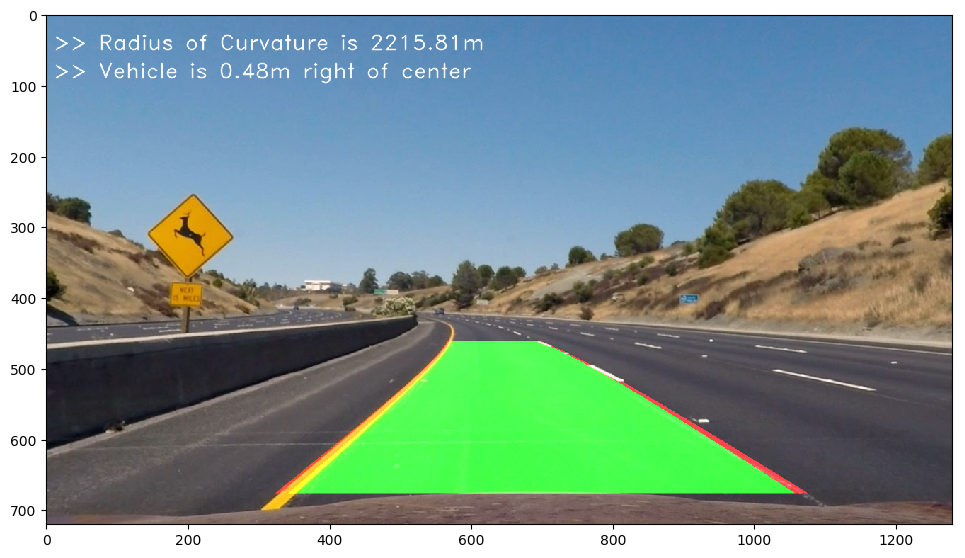

In [20]:
plt.close('all')
# for idx in range(7):
idx =3
reset_buffer()
# print(bmodel)
image, prefix = get_test_image(idx)
# prefix = None
result = find_pipelines_and_green_zone(image,objpoints, imgpoints, prefix=prefix, _plot = False)
# print(bmodel)
fig = get_new_figure()
# cv2.imshow('res',result)
plt.imshow(result)
plt.draw()

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_pipelines_and_green_zone(image,objpoints, imgpoints)
    
    return result

In [23]:
_output = 'output/project_video.mp4'
# white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
reset_buffer()
# clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(19,25)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(_output, audio=False)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [10:34<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

Wall time: 10min 34s


In [31]:
# _output = 'output/challenge_video.mp4'
# # white_output = 'test_videos_output/solidYellowLeft.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# reset_buffer()
# clip1 = VideoFileClip("test_videos/challenge_video.mp4")
# # clip1 = VideoFileClip("test_videos/challenge_video.mp4").subclip(0,2)
# # clip1 = VideoFileClip("test_videos/challenge_video.mp4")
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(_output, audio=False)

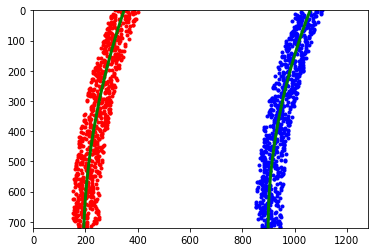

In [33]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
[toc]